In [4]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

## 1. Scrape Data

In [101]:
def tweet_scraper(query, n_tweet):
    attributes_container = []
    max_tweet = n_tweet

    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):

        if i>max_tweet:
            break
        
        attributes_container.append([tweet.user.username,
                                 tweet.user.verified,
                                 tweet.user.created,
                                 tweet.user.followersCount,
                                 tweet.user.friendsCount,
                                 tweet.user.location,
                                 tweet.retweetCount,
                                 tweet.lang,
                                 tweet.date,
                                 tweet.likeCount,
                                 tweet.sourceLabel,
                                 tweet.id,
                                 tweet.content,
                                 tweet.hashtags,
                                 tweet.conversationId,
                                 tweet.inReplyToUser,
                                 tweet.coordinates,
                                 tweet.place])
    
    return pd.DataFrame(attributes_container, columns=["User",
                                                   "verified",
                                                   "Date_Created",
                                                   "Follows_Count",
                                                   "Friends_Count",
                                                   "User_Location",
                                                   "Retweet_Count",
                                                   "Language",
                                                   "Date_Tweet",
                                                   "Number_of_Likes",
                                                   "Source_of_Tweet",
                                                   "Tweet_Id",
                                                   "Tweet",
                                                   "Hashtags",
                                                   "Conversation_Id",
                                                   "In_reply_To",
                                                   "Coordinates",
                                                   "Place"])

In [102]:
df_tag = tweet_scraper('#stoicism since:2018-07-05 until:2022-10-06', 10000)

In [61]:
import os

In [103]:
# save data
outname = 'stoic_tweets.csv'
outdir = './data'
fullname = os.path.join(outdir, outname)
df_tag.to_csv(fullname) # exported as clean data w/ sentiment columns below

In [104]:
df_tag = pd.read_csv('./data/stoic_tweets.csv') 

In [105]:
df_tag[['User', 'User_Location', 'Date_Tweet', 'Tweet', 'Hashtags']].head()

,User,User_Location,Date_Tweet,Tweet,Hashtags
0,BanjokoAdisa,San Francisco/London/Leeds,2022-10-05 23:55:02+00:00,Really cool article by @DonJRobertson on beati...,"['stoicism', 'stoic']"
1,SharpeAuthor,"Melbourne,Australia",2022-10-05 23:34:04+00:00,"Craig Challen, Australian diver from the 2018 ...","['Courage', 'servicepublic', 'stoicism']"
2,jugarselapiel,México,2022-10-05 22:03:00+00:00,"Frase Diaria de ""Jugarse la Piel"" por Nassim T...","['taleb', 'skininthegame', 'nassimtaleb', 'bla..."
3,SharpeAuthor,"Melbourne,Australia",2022-10-05 21:14:57+00:00,"#stoicism: ""Zeno said, “The right way to seize...",['stoicism']
4,TKGore,"Chicago (via DC, Philly)",2022-10-05 20:54:53+00:00,Just arrived!💥Thank you @RyanHoliday for bring...,['stoicism']


## 2. Clean Data

In [15]:
import requests # download texts
import re # work with regular expressions
import numpy as np

# NLP
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

# data viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.rc('figure',figsize=(13,9))
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
from wordcloud import WordCloud,STOPWORDS

import warnings
warnings.filterwarnings("ignore")

In [106]:
# remove twitter handles
df_tag.Tweet = df_tag.Tweet.apply(lambda x:re.sub('@[^\s]+','',x))

# remove hastags
df_tag.Tweet = df_tag.Tweet.apply(lambda x:re.sub(r'\B#\S+','',x))

# remove URLS
df_tag.Tweet = df_tag.Tweet.apply(lambda x:re.sub(r"http\S+", "", x))

# remove all the special characters
df_tag.Tweet = df_tag.Tweet.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
df_tag.Tweet = df_tag.Tweet.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# substituting multiple spaces with single space
df_tag.Tweet = df_tag.Tweet.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

<>:2: DeprecationWarning:

invalid escape sequence \s

<>:2: DeprecationWarning:

invalid escape sequence \s

/var/folders/3g/vjzcw6050n34kshmr3dgry980000gp/T/ipykernel_23156/3253950027.py:2: DeprecationWarning:

invalid escape sequence \s



## 3. Explore Data

### 3.1 VADER sentiment analysis

In [116]:
sid = SIA()
df_tag['sentiments'] = df_tag['Tweet'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
df_tag['Positive Sentiment'] = df_tag['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
df_tag['Neutral Sentiment'] = df_tag['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
df_tag['Negative Sentiment'] = df_tag['sentiments'].apply(lambda x: x['neg']+1*(10**-6))
df_tag['Compound Sentiment'] = df_tag['sentiments'].apply(lambda x: x['compound'])

df_tag.drop(columns=['sentiments'],inplace=True)
# df_tag.sort_values(by='Date_Tweet')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


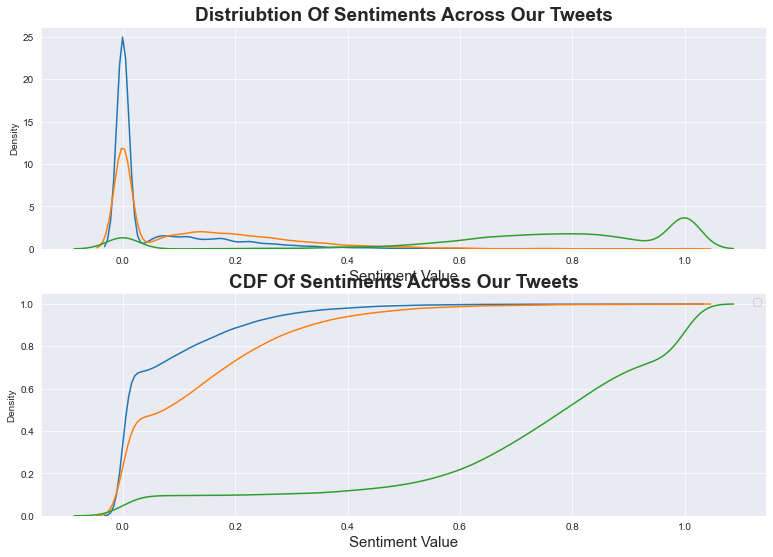

In [108]:
plt.subplot(2,1,1)
plt.title('Distriubtion Of Sentiments Across Our Tweets',fontsize=19,fontweight='bold')
sns.kdeplot(df_tag['Negative Sentiment'],bw=0.1)
sns.kdeplot(df_tag['Positive Sentiment'],bw=0.1)
sns.kdeplot(df_tag['Neutral Sentiment'],bw=0.1)
plt.xlabel('Sentiment Value',fontsize=15)

plt.subplot(2,1,2)
plt.title('CDF Of Sentiments Across Our Tweets',fontsize=19,fontweight='bold')
sns.kdeplot(df_tag['Negative Sentiment'],bw=0.1,cumulative=True)
sns.kdeplot(df_tag['Positive Sentiment'],bw=0.1,cumulative=True)
sns.kdeplot(df_tag['Neutral Sentiment'],bw=0.1,cumulative=True)
plt.xlabel('Sentiment Value',fontsize=15)
plt.legend()
plt.show()

Neutral proves to be the more dominant sentiment as its distribution is skewed towards the right. Positive and negative sentiments are similar with a peak at 0, meaning the sentiments identified are not as strong

### 3.2 Time based analysis

In [109]:
#Sorting And Feature Engineering
df_tag = df_tag.sort_values(by='Date_Tweet')
df_tag=df_tag.copy()
df_tag['Date_Tweet'] = pd.to_datetime(df_tag['Date_Tweet']).dt.date
df_tag.columns[-3:]

Index(['Positive Sentiment', 'Neutral Sentiment', 'Negative Sentiment'], dtype='object')

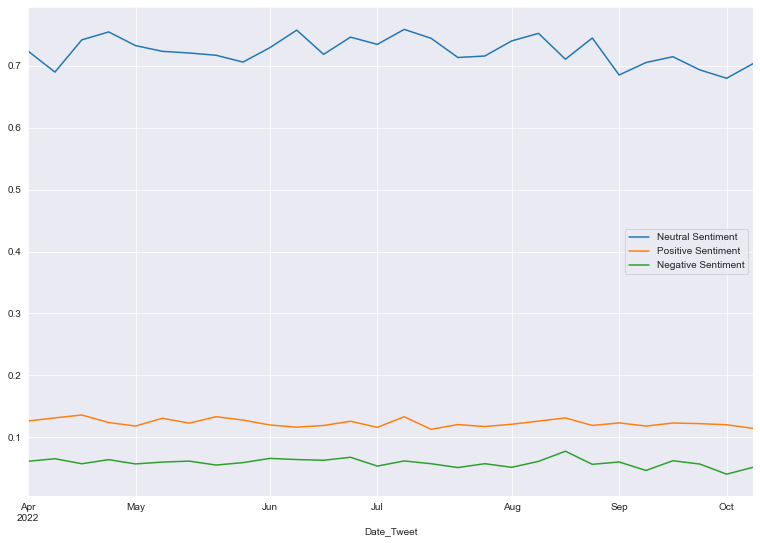

In [122]:
df_test = df_tag
df_test['Date_Tweet'] = pd.to_datetime(df_test['Date_Tweet'])
df_test = df_test.set_index('Date_Tweet')
df_test.resample('W')['Neutral Sentiment'].mean().plot()
df_test.resample('W')['Positive Sentiment'].mean().plot()
df_test.resample('W')['Negative Sentiment'].mean().plot().legend()

In [111]:
b_date_mean = df_tag.groupby(by='Date_Tweet').mean().reset_index()
b_date_std = df_tag.groupby(by='Date_Tweet').std().reset_index()


fig = make_subplots(rows=3, cols=1,shared_xaxes=True,subplot_titles=('Daily Average Positive Sentiment',  'Daily Average Negative Sentiment', 'Daily Average Neutral Sentiment'))

fig.add_trace(
    go.Scatter(x=b_date_mean['Date_Tweet'], y=b_date_mean['Positive Sentiment'],name='Positive Sentiment Mean'),
    row=1, col=1
)

    
#positive mean
fig.add_hline(y=b_date_mean['Positive Sentiment'].mean(), line_dash = 'dash', row=1, col=1)

fig.add_annotation(x=b_date_mean['Date_Tweet'].values[3], y=b_date_mean['Positive Sentiment'].mean(),
            text=r"$\mu : {:.2f}$".format(b_date_mean['Positive Sentiment'].mean()),
            showarrow=True,
            arrowhead=3,
            yshift=10)



fig.add_trace(
    go.Scatter(x=b_date_mean['Date_Tweet'], y=b_date_mean['Negative Sentiment'],name='Negative Sentiment Mean'),
    row=2, col=1
)


#negative mean
fig.add_hline(y=b_date_mean['Negative Sentiment'].mean(), line_dash = 'dash', row=2, col=1)

fig.add_annotation(x=b_date_mean['Date_Tweet'].values[3], y=b_date_mean['Negative Sentiment'].mean(),
            text=r"$\mu : {:.2f}$".format(b_date_mean['Negative Sentiment'].mean()),
            showarrow=True,
            arrowhead=3,
            yshift=10,
            xref='x2', 
            yref='y2')

fig.add_trace(
    go.Scatter(x=b_date_mean['Date_Tweet'], y=b_date_mean['Neutral Sentiment'],name='Neutral Sentiment Mean'),
    row=3, col=1
)

fig.add_hline(y=b_date_mean['Neutral Sentiment'].mean(), line_dash = 'dash', row=3, col=1)

fig.add_annotation(x=b_date_mean['Date_Tweet'].values[3], y=b_date_mean['Neutral Sentiment'].mean(),
            text=r"$\mu : {:.2f}$".format(b_date_mean['Neutral Sentiment'].mean()),
            showarrow=True,
            arrowhead=3,
            yshift=10, 
            xref='x3', 
            yref='y3')

'''

fig.add_annotation(x=b_date_mean['pubdate'].values[5], y=b_date_mean['Negative Sentiment'].mean()+0.01,
            text=r"Start Of Decline",
            showarrow=True,
            arrowhead=6,
            yshift=10,
            xref='x2', 
            yref='y2')

fig.add_annotation(x=b_date_mean['pubdate'].values[9], y=.024,
            text=r"Start Of Incline",
            showarrow=True,
            arrowhead=6,
            yshift=10,
            xref='x2', 
            yref='y2')


fig['layout']['xaxis2']['title'] = 'Date'
fig.update_layout(height=700, width=900, title_text="Sentiment Average Change With Time")
'''
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()


/Users/stellajia/opt/miniconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/stellajia/opt/miniconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



### Another approach to sentiment scores

In [117]:
df_tag[['Compound Sentiment']]

,Compound Sentiment
10000,-0.5096
9999,-0.5994
9998,-0.4019
9997,-0.4585
9996,0.7650
...,...
4,0.7717
3,-0.2263
2,0.0000
1,0.5106


In [119]:
b_date_mean = df_tag.groupby(by='Date_Tweet').mean().reset_index()
b_date_std = df_tag.groupby(by='Date_Tweet').std().reset_index()


fig = make_subplots(rows=1, cols=1,shared_xaxes=True,subplot_titles=('Daily Average Sentiment'))

fig.add_trace(
    go.Scatter(x=b_date_mean['Date_Tweet'], y=b_date_mean['Compound Sentiment'],name='Sentiment Mean'),
    row=1, col=1
)

    
# mean
fig.add_hline(y=b_date_mean['Compound Sentiment'].mean(), line_dash = 'dash', row=1, col=1)

fig.add_annotation(x=b_date_mean['Date_Tweet'].values[3], y=b_date_mean['Compound Sentiment'].mean(),
            text=r"$\mu : {:.2f}$".format(b_date_mean['Compound Sentiment'].mean()),
            showarrow=True,
            arrowhead=3,
            yshift=10)

/Users/stellajia/opt/miniconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/stellajia/opt/miniconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



<AxesSubplot:xlabel='Date_Tweet'>

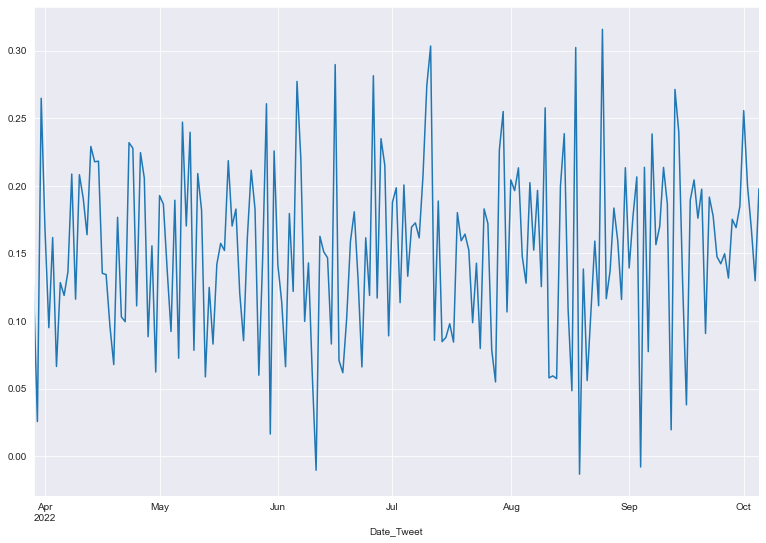

In [129]:
df_test.resample('D')['Compound Sentiment'].mean().plot()

### 3.3 Geotagging

In [55]:
# 2948 tweets have no location
fig = ex.bar(x=df_tag.User_Location.value_counts()[1:20].index, y=df_tag.User_Location.value_counts()[1:20].values, 
             title='Top 20 Locations Contributing to Stoicism')
fig.show()

## 4. Topic Model

In [56]:
# more NLP packages
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

# more data viz packages
import pyLDAvis.gensim_models
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls

2022-12-02 20:40:54.674277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [57]:
# new df with just tweets
df = pd.DataFrame()
df['tweets'] = df_tag['Tweet']
# df = df.reset_index()
df.head()

,tweets
10000,It takes the whole of life to learn how to liv...
9983,Stoicism is designed to be the medicine of the...
9990,Tranquility Believing in yourself and trusting...
9999,Complaints aredirect result of oneexpectations
9998,If you donregard what you have as enough you w...


In [58]:
# load in spacy (pre-trained NLP model able to figure out relationships between words)
nlp = spacy.load('en_core_web_lg')

In [59]:
# tokenize
tokenizer = Tokenizer(nlp.vocab)


# Custom stopwords
custom_stopwords = ['hi','\n','\n\n', '&', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(df['tweets'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
df['tokens'] = tokens
df.head()

,tweets,tokens
10000,It takes the whole of life to learn how to liv...,"[takes, life, learn, live, takes, life, learn,..."
9983,Stoicism is designed to be the medicine of the...,"[stoicism, designed, medicine, soul, relieves,..."
9990,Tranquility Believing in yourself and trusting...,"[tranquility, believing, trusting, right, path..."
9999,Complaints aredirect result of oneexpectations,"[complaints, aredirect, result, oneexpectations]"
9998,If you donregard what you have as enough you w...,"[donregard, happy, rule, entire, world, person..."


In [60]:
# lemmatization
# Make tokens a string again
df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df['lemmas'] = df['tokens_back_to_text'].apply(get_lemmas)
df.head()

,tweets,tokens,tokens_back_to_text,lemmas
10000,It takes the whole of life to learn how to liv...,"[takes, life, learn, live, takes, life, learn,...",takes life learn live takes life learn die luc...,"[take, life, learn, live, take, life, learn, d..."
9983,Stoicism is designed to be the medicine of the...,"[stoicism, designed, medicine, soul, relieves,...",stoicism designed medicine soul relieves vulne...,"[stoicism, design, medicine, soul, relieve, vu..."
9990,Tranquility Believing in yourself and trusting...,"[tranquility, believing, trusting, right, path...",tranquility believing trusting right path doub...,"[tranquility, believe, trust, right, path, dou..."
9999,Complaints aredirect result of oneexpectations,"[complaints, aredirect, result, oneexpectations]",complaints aredirect result oneexpectations,"[complaint, aredirect, result, oneexpectation]"
9998,If you donregard what you have as enough you w...,"[donregard, happy, rule, entire, world, person...",donregard happy rule entire world person littl...,"[donregard, happy, rule, entire, world, person..."


In [66]:
# Make lemmas a string again
df['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df['lemmas']]

# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    # tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    # tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    # tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df['lemma_tokens'] = df['lemmas_back_to_text'].apply(tokenize)
df.head()

,tweets,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens
10000,It takes the whole of life to learn how to liv...,"[takes, life, learn, live, takes, life, learn,...",takes life learn live takes life learn die luc...,"[take, life, learn, live, take, life, learn, d...",take life learn live take life learn die luciu...,"[take, life, learn, live, take, life, learn, d..."
9983,Stoicism is designed to be the medicine of the...,"[stoicism, designed, medicine, soul, relieves,...",stoicism designed medicine soul relieves vulne...,"[stoicism, design, medicine, soul, relieve, vu...",stoicism design medicine soul relieve vulnerab...,"[stoicism, design, medicine, soul, relieve, vu..."
9990,Tranquility Believing in yourself and trusting...,"[tranquility, believing, trusting, right, path...",tranquility believing trusting right path doub...,"[tranquility, believe, trust, right, path, dou...",tranquility believe trust right path doubtampa...,"[tranquility, believe, trust, right, path, dou..."
9999,Complaints aredirect result of oneexpectations,"[complaints, aredirect, result, oneexpectations]",complaints aredirect result oneexpectations,"[complaint, aredirect, result, oneexpectation]",complaint aredirect result oneexpectation,"[complaint, aredirect, result, oneexpectation]"
9998,If you donregard what you have as enough you w...,"[donregard, happy, rule, entire, world, person...",donregard happy rule entire world person littl...,"[donregard, happy, rule, entire, world, person...",donregard happy rule entire world person littl...,"[donregard, happy, rule, entire, world, person..."


In [67]:
# Create a id2word dictionary
id2word = Dictionary(df['lemma_tokens'])
print(len(id2word))

14608


In [68]:
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

5416


In [77]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df['lemma_tokens']]

# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=10, id2word=id2word, workers=12, passes=5)

# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

# Create Topics
topics = [' '.join(t[0:10]) for t in words]

In [78]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
stoic amp aurelius way marcus good great epictetus link remember

------ Topic 1 ------
change life choice wisdom world stoic know day thing karen

------ Topic 2 ------
marcus aurelius think amp love life people good read stoic

------ Topic 3 ------
life stoicism philosophy act gift right check grab sell 95

------ Topic 4 ------
good thing aurelius marcus de man la epictetus stoic stoicism

------ Topic 5 ------
day stoic daily 365 remember aurelius marcus devotional new sleep

------ Topic 6 ------
stoic seneca well day today time people power good work

------ Topic 7 ------
seneca life happen epictetus man suffer time live world wish

------ Topic 8 ------
life aurelius marcus mind thing control good stoic think read

------ Topic 9 ------
thing people control epictetus think day seneca stoic good stoicism



In [79]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(base_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.127510 -0.017137       1        1  14.332562
5      0.152182 -0.029420       2        1  12.000855
2      0.000217 -0.075071       3        1  11.312565
8     -0.013069 -0.013413       4        1  10.822133
9     -0.032027  0.018262       5        1   9.527383
7     -0.032089  0.147936       6        1   8.988254
6      0.045382  0.031866       7        1   8.861742
4     -0.088973 -0.073621       8        1   8.707444
0      0.054240 -0.077255       9        1   7.967719
1      0.041647  0.087851      10        1   7.479342, topic_info=          Term        Freq       Total Category  logprob  loglift
46         day  622.000000  622.000000  Default  30.0000  30.0000
1939      gift  261.000000  261.000000  Default  29.0000  29.0000
2022        95  212.000000  212.000000  Default  28.0000  28.0000
1020      grab  233.000000  233.000000  Default  27.0000  27.0000
3701       365  213.000000  213.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
425       2022   22.403822   94.449556  Topic10  -5.5303   1.1542
3         live   23.489494  380.810676  Topic10  -5.4830  -0.1927
159     marcus   24.579618  803.776902  Topic10  -5.4376  -0.8944
156   aurelius   24.393773  798.535845  Topic10  -5.4452  -0.8954
170       mind   23.047953  342.046693  Topic10  -5.5020  -0.1043

[740 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1025      1  0.881783        00
1025     10  0.067829        00
124       1  0.132295         1
124       2  0.049611         1
124       3  0.124027         1
...     ...       ...       ...
4637      1  0.823627   youlove
4637      3  0.082363   youlove
1464      6  0.807065  younger4
3661      7  0.781844  youthful
5398      7  0.839591     zuban

[2531 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 3, 9, 10, 8, 7, 5, 1, 2])